In [19]:
# Import Libraries
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from keras import regularizers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [20]:
# Import Data (Insert your path here)
path_A = '/Users/las/Documents/GitHub/REU/Data/data_A.csv'
path_B = '/Users/las/Documents/GitHub/REU/Data/data_B.csv'
df_A = pd.read_csv(path_A)
df_B = pd.read_csv(path_B)
df_A[df_A.no % 2==1] = df_A[df_A.no % 2==1] + 1 
df_B[df_B.no % 2==1] = df_B[df_B.no % 2==1] + 1 

In [21]:
# Create Training and Validation Data (A)
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(
    df_A.drop("no", axis=1).astype('float64'),
    df_A["no"]//2, 
    test_size=0.2, random_state=42)

X_train_A, X_test_A, y_train_A, y_test_A = np.asarray(X_train_A), np.asarray(X_test_A), np.asarray(y_train_A), np.asarray(y_test_A)
print(f"(A): There a {len(X_train_A)} training samples and {len(X_test_A)} test samples.")

# Create Training and Validation Data (B)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    df_B.drop("no", axis=1).astype('float64'),
    df_B["no"]//2, 
    test_size=0.2, random_state=42)

X_train_B, X_test_B, y_train_B, y_test_B = np.asarray(X_train_B), np.asarray(X_test_B), np.asarray(y_train_B), np.asarray(y_test_B)
print(f"(B): There a {len(X_train_B)} training samples and {len(X_test_B)} test samples.")

# Create Training and Validation Data (AB)
X_train_AB, X_test_AB, y_train_AB, y_test_AB = train_test_split(
    df_A.drop("no", axis=1).append(df_B.drop("no", axis=1)).astype('float64'),
    df_A.append(df_B)["no"]//2, 
    test_size=0.2, random_state=42)

X_train_AB, X_test_AB, y_train_AB, y_test_AB = np.asarray(X_train_AB), np.asarray(X_test_AB), np.asarray(y_train_AB), np.asarray(y_test_AB)
print(f"(AB): There a {len(X_train_AB)} training samples and {len(X_test_AB)} test samples.")

(A): There a 40000 training samples and 10000 test samples.
(B): There a 40000 training samples and 10000 test samples.
(AB): There a 80000 training samples and 20000 test samples.


In [22]:
# Set Up Network Architectures
model_A = keras.Sequential([
    keras.layers.Dense(units=1000, activation='relu', input_shape=(18,)),
    keras.layers.Dense(units=1000, activation='relu'),
    keras.layers.Dense(units=93, activation='softmax')
])

model_B = keras.Sequential([
    keras.layers.Dense(units=1000, activation='relu', input_shape=(18,)),
    keras.layers.Dense(units=1000, activation='relu'),
    keras.layers.Dense(units=93, activation='softmax')
])

model_AB = keras.Sequential([
    keras.layers.Dense(units=1000, activation='relu', input_shape=(18,), kernel_regularizer='l1_l2'),
    keras.layers.Dropout(.1),
    keras.layers.Dense(units=1000, activation='relu'),
    keras.layers.Dropout(.1),
    keras.layers.Dense(units=93, activation='softmax')
])
model_A.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 1000)              19000     
_________________________________________________________________
dense_28 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_29 (Dense)             (None, 93)                93093     
Total params: 1,113,093
Trainable params: 1,113,093
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Set up training
sce = keras.losses.SparseCategoricalCrossentropy()
model_A.compile(optimizer='Adam', loss=sce, metrics=['accuracy', sce])
model_B.compile(optimizer='Adam', loss=sce, metrics=['accuracy', sce])
model_AB.compile(optimizer='Adam', loss=sce, metrics=['accuracy', sce])

/Users/las/opt/anaconda3/envs/REU/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


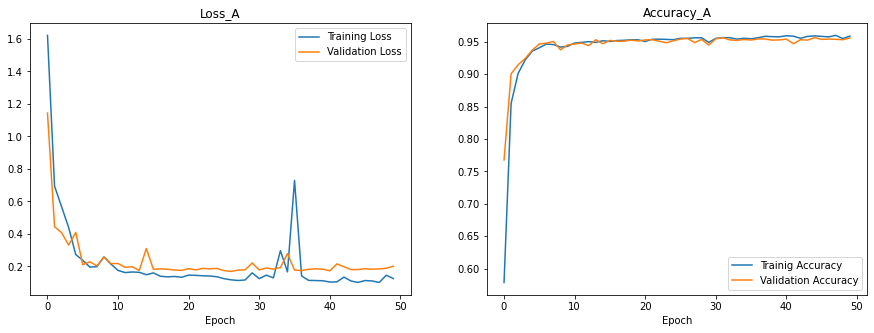

In [24]:
#Model A
history_A = model_A.fit(
    X_train_A,
    y_train_A,
    verbose=0,
    epochs=50,
    batch_size=64,
    validation_data=(
        X_test_A,
        y_test_A
    )
)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history_A.history['loss'], label="Training Loss") 
axs[0].plot(history_A.history['val_loss'], label="Validation Loss")
axs[0].set_title("Loss_A")
axs[0].legend(loc="upper right")
axs[1].plot(history_A.history['accuracy'], label="Trainig Accuracy") 
axs[1].plot(history_A.history['val_accuracy'], label="Validation Accuracy")
axs[1].legend(loc="lower right")
axs[1].set_title("Accuracy_A")
axs[1].sharex(axs[0])

for ax in axs.flat:
    ax.set(xlabel='Epoch')
fig.show()

In [25]:
#Evaluate Model A
pred_A_A = 2*np.argmax(model_A.predict(df_A.drop("no", axis=1)),axis=1)
pred_A_B = 2*np.argmax(model_A.predict(df_B.drop("no", axis=1)),axis=1)
pred_A_AB = 2*np.argmax(model_A.predict(df_A.append(df_B).drop("no", axis=1)),axis=1)

print(f"Accuracy of model_A on A: {history_A.history['val_accuracy'][-1]}")
print(f"Accuracy of model_A on B: {len(df_B[df_B.no==pred_A_B])/50000}")
print(f"Accuracy of model_A on AB: {(len(df_A[df_A.no==pred_A_AB[:50000]])+len(df_B[df_B.no==pred_A_AB[50000:]]))/100000}")

Accuracy of model_A on A: 0.9559000134468079
Accuracy of model_A on B: 0.03678
Accuracy of model_A on AB: 0.49879


/Users/las/opt/anaconda3/envs/REU/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


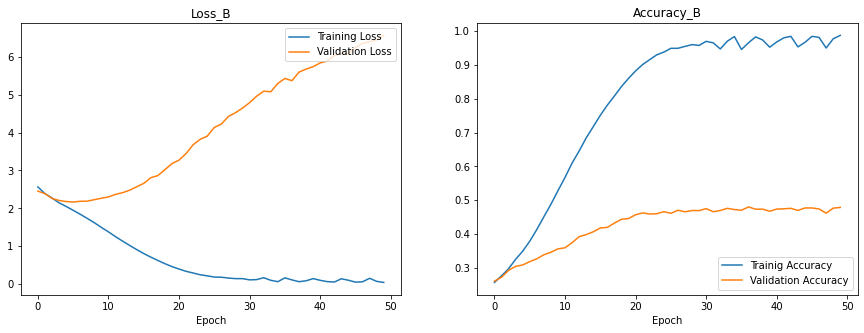

In [26]:
history_B = model_B.fit(
    X_train_B,
    y_train_B,
    verbose=0,
    epochs=50,
    batch_size=64,
    validation_data=(
        X_test_B,
        y_test_B
    )
)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history_B.history['loss'], label="Training Loss") 
axs[0].plot(history_B.history['val_loss'], label="Validation Loss")
axs[0].set_title("Loss_B")
axs[0].legend(loc="upper right")
axs[1].plot(history_B.history['accuracy'], label="Trainig Accuracy") 
axs[1].plot(history_B.history['val_accuracy'], label="Validation Accuracy")
axs[1].legend(loc="lower right")
axs[1].set_title("Accuracy_B")
axs[1].sharex(axs[0])

for ax in axs.flat:
    ax.set(xlabel='Epoch')
fig.show()

In [27]:
#Evaluate Model B
pred_B_A = 2*np.argmax(model_B.predict(df_A.drop("no", axis=1)),axis=1)
pred_B_B = 2*np.argmax(model_B.predict(df_B.drop("no", axis=1)),axis=1)
pred_B_AB = 2*np.argmax(model_B.predict(df_A.append(df_B).drop("no", axis=1)),axis=1)

print(f"Accuracy of model_B on A: {len(df_A[df_A.no==pred_B_A])/50000}")
print(f"Accuracy of model_B on B: {history_B.history['val_accuracy'][-1]}") 
print(f"Accuracy of model_B on AB: {(len(df_A[df_A.no==pred_B_AB[:50000]])+len(df_B[df_B.no==pred_B_AB[50000:]]))/100000}")

Accuracy of model_B on A: 0.03922
Accuracy of model_B on B: 0.47839999198913574
Accuracy of model_B on AB: 0.46243


/Users/las/opt/anaconda3/envs/REU/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


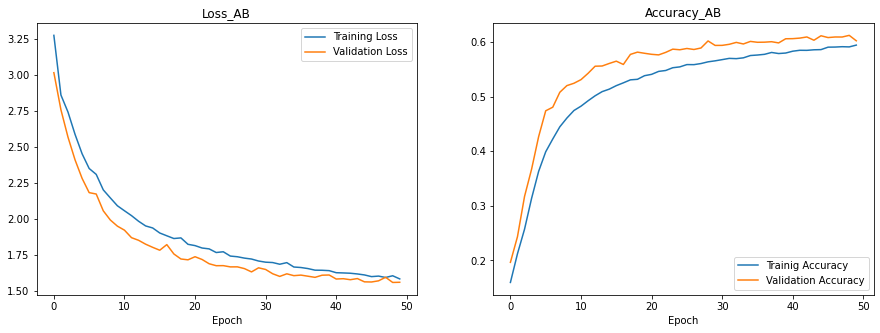

In [28]:
history_AB = model_AB.fit(
    X_train_AB,
    y_train_AB,
    verbose=0,
    epochs=50,
    batch_size=64,
    validation_data=(
        X_test_AB,
        y_test_AB
    )
)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history_AB.history['loss'], label="Training Loss") 
axs[0].plot(history_AB.history['val_loss'], label="Validation Loss")
axs[0].set_title("Loss_AB")
axs[0].legend(loc="upper right")
axs[1].plot(history_AB.history['accuracy'], label="Trainig Accuracy") 
axs[1].plot(history_AB.history['val_accuracy'], label="Validation Accuracy")
axs[1].legend(loc="lower right")
axs[1].set_title("Accuracy_AB")
axs[1].sharex(axs[0])

for ax in axs.flat:
    ax.set(xlabel='Epoch')
fig.show()

In [31]:
#Evaluate Model AB
pred_AB_A = 2*np.argmax(model_AB.predict(df_A.drop("no", axis=1)),axis=1)
pred_AB_B = 2*np.argmax(model_AB.predict(df_B.drop("no", axis=1)),axis=1)
pred_AB_AB = 2*np.argmax(model_AB.predict(df_A.append(df_B).drop("no", axis=1)),axis=1)

print(f"Accuracy of model_AB on A: {len(df_A[df_A.no==pred_AB_A])/50000}")
print(f"Accuracy of model_AB on B: {len(df_B[df_B.no==pred_AB_B])/50000}") 
print(f"Accuracy of model_AB on AB: {history_AB.history['val_accuracy'][-1]}")

Accuracy of model_AB on A: 0.90766
Accuracy of model_AB on B: 0.3856
Accuracy of model_AB on AB: 0.6093500256538391
